# **DA5401 A7: Multi-Class Model Selection using ROC and Precision-Recall Curves**

## Objective: 
The objective of this project is to **develop and evaluate multiple machine learning models** for **multi-class land-cover classification** using **Landsat satellite imagery**.  
Each pixel is characterized by 36 spectral bands, and the task is to accurately assign it to one of several **terrain or land-cover classes**.

The goal is to:
- Compare model performance across metrics such as **Accuracy**, **Weighted F1-Score**, **ROC-AUC**, and **Precision–Recall AP**.  
- Analyze model behavior under varying decision thresholds using **One-vs-Rest (OvR)** multi-class ROC and PRC curves.  
- Identify the model that best balances **discriminative power**, **precision**, and **recall** for robust and generalizable classification performance.

# Part A: Data Preparation and Baseline

In [1]:
import os
import re
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

## 1. Load and Prepare Data:

In [2]:
# 1. Download all data files
base_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/satimage/"
files = ["sat.trn", "sat.tst", "sat.doc"]

for f in files:
    dest = f"{f}"
    if not os.path.exists(dest):
        print(f"Downloading {f}...")
        urllib.request.urlretrieve(base_url + f, dest)
    else:
        print(f"{f} already exists.")

sat.trn already exists.
sat.tst already exists.
sat.doc already exists.


In [3]:
# 2. Load training/test data
col_names = [f"band_{i+1}" for i in range(36)] + ["label"]
train_df = pd.read_csv("sat.trn", sep=r"\s+", header=None, names=col_names)
test_df  = pd.read_csv("sat.tst", sep=r"\s+", header=None, names=col_names)
full_df  = pd.concat([train_df, test_df], axis=0).dropna().reset_index(drop=True)

In [4]:
print(f"Train shape: {train_df.shape}")
print(f"Test shape:  {test_df.shape}")

Train shape: (4435, 37)
Test shape:  (2000, 37)


In [5]:
full_df.isnull().sum().any()

np.False_

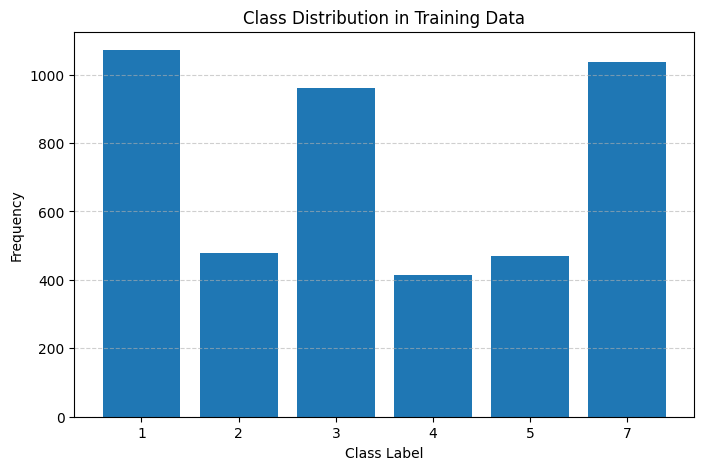

In [6]:
label_counts = train_df["label"].value_counts().sort_index()

plt.figure(figsize=(8,5))
plt.bar(label_counts.index.astype(str), label_counts.values)
plt.title("Class Distribution in Training Data")
plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [7]:
# Extract class info using regex
with open("sat.doc", "r") as f:
    doc_text = f.read()
pattern = r"(\d+)\s+([a-zA-Z\s\(\)\-]+)"
class_section = re.search(r"Number\s+Class(.*?)NB", doc_text, re.S)

if class_section:
    class_text = class_section.group(1)
    class_metadata = dict(re.findall(pattern, class_text))
    class_metadata = {int(k): v.strip() for k, v in class_metadata.items()}

print("Extracted Class Metadata from sat.doc:")
for k, v in class_metadata.items():
    print(f"  {k}: {v}")

Extracted Class Metadata from sat.doc:
  1: red soil
  2: cotton crop
  3: grey soil
  4: damp grey soil
  5: soil with vegetation stubble
  6: mixture class (all types present)
  7: very damp grey soil


In [8]:
# It doesn't have label 6 (All types present) anyways
missing_classes = set(class_metadata.keys()) - set(label_counts.index)
print("Missing classes:", missing_classes)

Missing classes: {6}


In [9]:
X = full_df.drop(columns=["label"]).values
y = full_df["label"].values

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 2. Train/Test Split:

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

## 3. Train All Models:

In [12]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [13]:
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Dummy (Prior)": DummyClassifier(strategy="prior"),
    "Logistic Regression": LogisticRegression(max_iter=2000, multi_class="ovr"),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(probability=True, kernel="rbf", random_state=42)
}

## 4. Baseline Evaluation:

In [14]:
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    results.append({"Model": name, "Accuracy": acc, "Weighted F1": f1})

results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
print("\nBaseline Accuracy and F1 for all models:")
display(results_df.style.background_gradient(subset=["Accuracy", "Weighted F1"]))

c:\Users\Rishi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



Baseline Accuracy and F1 for all models:


,Model,Accuracy,Weighted F1
0,KNN,0.911422,0.909397
5,SVM,0.892774,0.891269
1,Decision Tree,0.846931,0.848079
3,Logistic Regression,0.832168,0.805687
4,Naive Bayes,0.783217,0.790059
2,Dummy (Prior),0.238539,0.091884


The baseline evaluation compares six classifiers: **KNN**, **SVM**, **Decision Tree**, **Logistic Regression**, **Naive Bayes**, and a **Dummy (Prior)** model — based on their **Overall Accuracy** and **Weighted F1-Score** on the test set.

| Model | Accuracy | Weighted F1 |
|:--|--:|--:|
| **KNN** | 0.9114 | 0.9094 |
| **SVM** | 0.8928 | 0.8913 |
| **Decision Tree** | 0.8469 | 0.8481 |
| **Logistic Regression** | 0.8322 | 0.8057 |
| **Naive Bayes** | 0.7832 | 0.7901 |
| **Dummy (Prior)** | 0.2385 | 0.0919 |

- **Top Performers:**  
  The **KNN** model achieves the highest accuracy (91.14%) and weighted F1 (0.909), indicating strong generalization and balance between precision and recall across classes. The **SVM** closely follows, suggesting that both models capture the underlying feature relationships effectively.

- **Moderate Models:**  
  **Decision Tree** and **Logistic Regression** perform reasonably well but show a noticeable performance drop, hinting at possible overfitting (in the tree) or limited decision boundary flexibility (in logistic regression).

- **Weaker Models:**  
  **Naive Bayes** underperforms relative to others, likely due to its strong independence assumptions, which may not hold in this dataset. This leads to miscalibrated probabilities and poorer F1 balance.

- **Baseline Reference (Dummy Model):**  
  The **Dummy (Prior)** classifier which simply predicts based on class frequency achieves only 23.85% accuracy and a very low weighted F1 of 0.09.  
  This establishes the **minimum expected performance**: any effective model must significantly exceed this benchmark.

### Inferences
- All trained models outperform the baseline by a large margin, confirming that meaningful patterns are being learned.  
- Among them, **KNN** and **SVM** stand out as the most effective initial classifiers for this task, showing both high accuracy and robust precision-recall balance.  
- These baseline metrics provide a reference point for deeper performance analysis in the next stages (ROC-AUC and PRC evaluations).


# Part B - ROC Analysis for Model Selection

## 1. Multi-Class ROC Calculation

In a multi-class classification problem, the standard ROC curve (which compares True Positive Rate vs False Positive Rate) is only defined for binary classification.  
To extend ROC analysis to multiple classes, we use the One-vs-Rest (OvR) approach:

- For each class i, we temporarily treat it as the “positive” class, and combine all other classes into a single “negative” class.  
- We then compute the ROC curve and Area Under the Curve (AUC) for this binary setup:

      AUC_i = ∫ TPR_i(FPR) d(FPR)

- Repeating this for all K classes gives K individual AUC values.
- Finally, we compute either:
  - The Macro-Average AUC → average of AUCs across all classes, treating each class equally, or  
  - The Weighted-Average AUC → weighted by each class’s sample count.

This approach provides a balanced evaluation of how well a model can distinguish each class from the others in a multi-class setting.


## 2. Plotting ROC

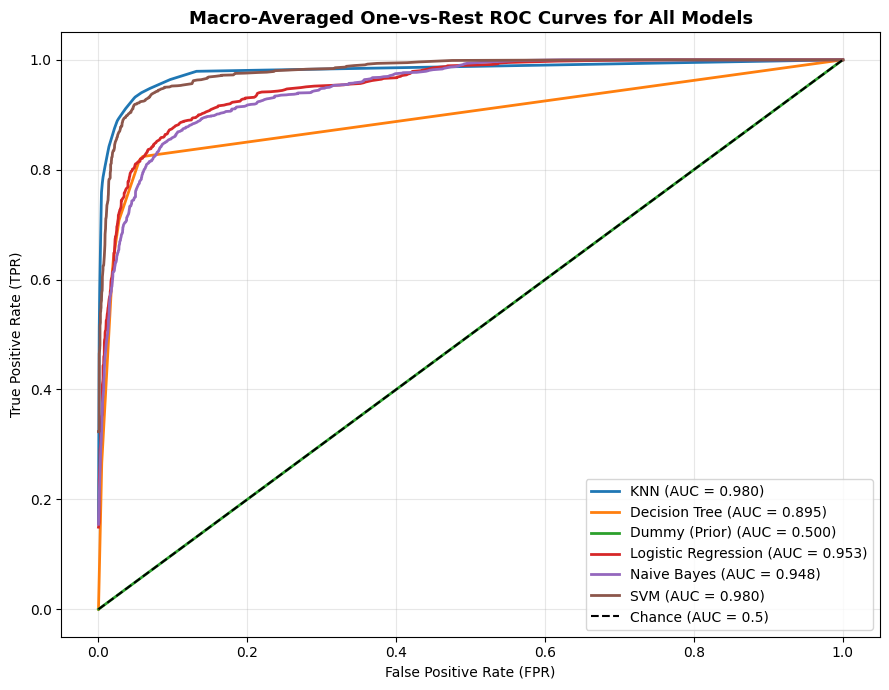

In [15]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from itertools import cycle

# Binarize labels for OvR (One-vs-Rest)
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)

# Prepare to store macro-average ROC/AUC results
roc_results = {}

plt.figure(figsize=(9, 7))

for name, model in models.items():
    # Predict probabilities (needed for ROC)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    else:
        # Fallback for models without predict_proba (shouldn’t occur since we set prob=True for SVM)
        try:
            y_score = model.decision_function(X_test)
        except:
            continue

    # Compute ROC curve and AUC for each class
    fpr, tpr, roc_auc = {}, {}, {}
    for i, cls in enumerate(classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute macro-average ROC curve
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(classes)

    macro_auc = auc(all_fpr, mean_tpr)
    roc_results[name] = macro_auc

    # Plot ROC curve
    plt.plot(all_fpr, mean_tpr, label=f"{name} (AUC = {macro_auc:.3f})", lw=2)

# Random-chance baseline
plt.plot([0, 1], [0, 1], "k--", lw=1.5, label="Chance (AUC = 0.5)")

plt.title("Macro-Averaged One-vs-Rest ROC Curves for All Models", fontsize=13, weight='bold')
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [16]:
# Show AUC summary
roc_auc_df = pd.DataFrame(list(roc_results.items()), columns=["Model", "Macro AUC"]).sort_values(by="Macro AUC", ascending=False)
print("\nMacro-Averaged AUC for Each Model:")
display(roc_auc_df.style.background_gradient(subset=["Macro AUC"]))


Macro-Averaged AUC for Each Model:


,Model,Macro AUC
0,KNN,0.980244
5,SVM,0.980171
3,Logistic Regression,0.952608
4,Naive Bayes,0.947689
1,Decision Tree,0.895178
2,Dummy (Prior),0.500000


## 3. ROC Interpretation

Model with the Highest Macro-Averaged AUC
From the results table:

| Model | Macro AUC |
|:------|-----------:|
| KNN | 0.9802 |
| SVM | 0.9801 |
| Logistic Regression | 0.9526 |
| Naive Bayes | 0.9477 |
| Decision Tree | 0.8952 |
| Dummy (Prior) | 0.5000 |

**KNN** achieved the highest macro-averaged AUC (0.9802), meaning it best distinguishes between all land-cover classes in the dataset.  
Its decision boundaries are flexible enough to adapt to non-linear class distributions, leading to excellent separability.

---

Model with AUC < 0.5  
The Dummy (Prior) classifier has an AUC = 0.5, which is equivalent to random guessing.  
An AUC value below 0.5 would indicate that the model’s predictions are worse than random — i.e., it ranks negative samples higher than positive ones.

**Conceptually:**
- AUC < 0.5 means the model’s confidence scores are inversely correlated with the actual labels.  
- It implies that the classifier consistently makes systematic misclassifications (e.g., due to inverted probabilities or misleading patterns).

**Why it happens:**
- The Dummy classifier predicts fixed class probabilities based only on class priors (no learning from features), so its ROC curve lies close to the diagonal.  
- Similarly, poorly calibrated or overfitted models may also exhibit AUC < 0.5 if their predicted probabilities are reversed or nonsensical.

| Metric | Best Model | AUC | Interpretation |
|:-------|:------------|:----|:---------------|
| Highest Macro-AUC | KNN | 0.980 | Best at distinguishing multiple land-cover types |
| Lowest AUC (~0.5) | Dummy (Prior) | 0.500 | Performs like random guessing, no discriminative ability |

# Part C - Precision-Recall Curve (PRC) Analysis

## 1. PRC Calculation 

**Why Precision–Recall (PR) is often better than ROC for imbalanced problems**

- **ROC (TPR vs FPR)** measures how well a classifier separates positives from negatives across thresholds. However, when the *positive class is rare*, the False Positive Rate (FPR) can remain very small even when the absolute number of false positives is large — this makes ROC curves overly optimistic.
- **Precision–Recall (Precision vs Recall)** directly captures the trade-off between:
  - **Precision** = TP / (TP + FP) - how many predicted positives are truly positive, and
  - **Recall** = TP / (TP + FN) - how many true positives are found.
- In imbalanced settings, **Precision responds to false positives** (which are costly when positive class is rare), so PR curves reveal degradations in performance that ROC can hide.
- Even if the dataset is only moderately imbalanced, PR curves are still informative because they focus on the positive-class prediction quality exactly what we often care about for minority classes.

**How we compute multi-class PRC with OvR**
- Like multi-class ROC, PRC is computed with **One-vs-Rest (OvR)**:
  - For each class \(i\) treat it as the positive class and all others as negative.
  - Compute the precision–recall curve (precision\( \, p_i(r) \) vs recall\( \, r \)) and the **Average Precision (AP)** (the area under the PR curve).
- To obtain an overall metric we can take:
  - **Macro-average AP** = mean(AP\(_i\)) across classes (treats classes equally), or
  - **Weighted-average AP** = weighted mean(AP\(_i\)) using class frequencies.
- For plotting a macro-average PR curve we typically:
  - Compute per-class `(precision, recall)` pairs.
  - Interpolate precisions at a common recall grid and average them to obtain a mean precision curve vs recall.


## 2. Plotting PRC

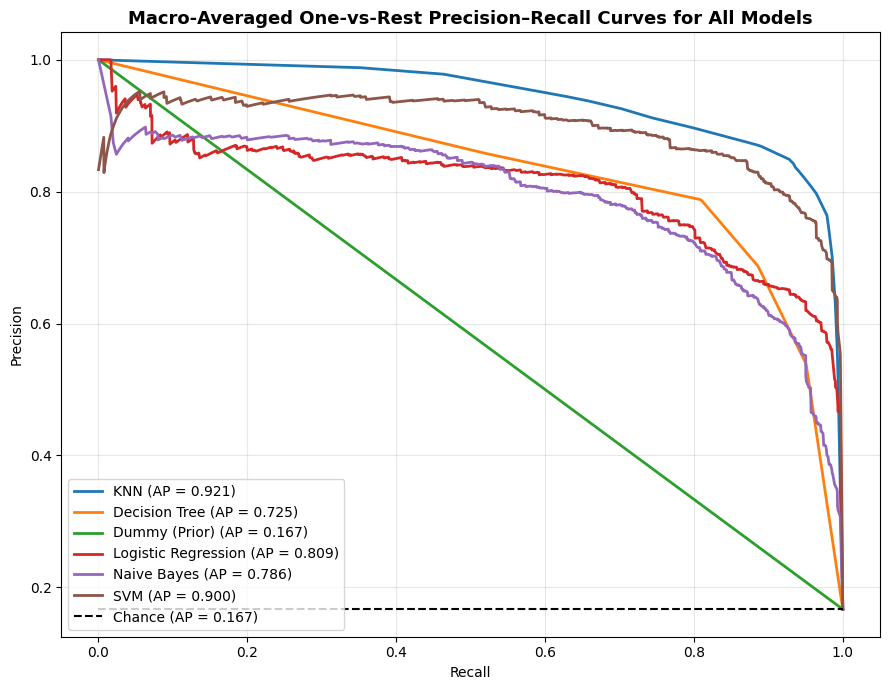

In [17]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Prepare to store macro-average PRC/AP results
prc_results = {}

plt.figure(figsize=(9, 7))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    else:
        try:
            y_score = model.decision_function(X_test)
        except:
            continue

    # Compute Precision-Recall curve for each class
    precision, recall, average_precision = {}, {}, {}
    for i, cls in enumerate(classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

    # Compute macro-average PR curve
    all_recalls = np.unique(np.concatenate([recall[i] for i in range(len(classes))]))
    mean_precision = np.zeros_like(all_recalls)
    for i in range(len(classes)):
        mean_precision += np.interp(all_recalls, recall[i][::-1], precision[i][::-1])
    mean_precision /= len(classes)

    macro_ap = np.mean(list(average_precision.values()))
    prc_results[name] = macro_ap

    plt.plot(all_recalls, mean_precision, lw=2, label=f"{name} (AP = {macro_ap:.3f})")

# Random baseline (constant precision = positive class fraction)
pos_fraction = (y_test_bin.sum() / y_test_bin.size)
plt.plot([0, 1], [pos_fraction, pos_fraction], "k--", lw=1.5, label=f"Chance (AP = {pos_fraction:.3f})")

plt.title("Macro-Averaged One-vs-Rest Precision–Recall Curves for All Models", fontsize=13, weight='bold')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
# Show Average Precision summary
prc_ap_df = pd.DataFrame(list(prc_results.items()), columns=["Model", "Macro AP"]).sort_values(by="Macro AP", ascending=False)
print("\nMacro-Averaged Average Precision (AP) for Each Model:")
display(prc_ap_df.style.background_gradient(subset=["Macro AP"]))


Macro-Averaged Average Precision (AP) for Each Model:


,Model,Macro AP
0,KNN,0.921463
5,SVM,0.899604
3,Logistic Regression,0.809155
4,Naive Bayes,0.785873
1,Decision Tree,0.724618
2,Dummy (Prior),0.166667


## 3. PRC Interpretation

### Model with the Highest Average Precision (mAP)

From the results table, **K-Nearest Neighbors (KNN)** achieved the highest **macro-averaged Average Precision (mAP = 0.921)**.  
This indicates that, across all one-vs-rest classes, KNN maintains both high **precision** and high **recall**.  
In practical terms, its predictions are confident and rarely confuse one land-cover type for another.  

KNN’s locally adaptive decision boundaries allow it to capture complex class structures in the feature space, which is advantageous in multi-spectral satellite imagery.


### Behavior of the Worst-Performing Model (Dummy Classifier)

The **Dummy (Prior)** classifier produced a very low **mAP = 0.167**, near the baseline for random guessing.  
Because it predicts classes only according to prior frequencies completely ignoring input features - its **precision drops sharply as recall increases**.

#### Why does the PR curve drop sharply for poor models?
- In early recall regions (low recall), the classifier may guess a few positives correctly by chance → temporarily high precision.  
- As the threshold relaxes (recall increases), the classifier starts labeling many more samples as positive, but most are **false positives**, so precision **rapidly falls**.  
- This produces a steep downward curve on the PR plot.  

Mathematically, $$\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}$$ falls as FP grows faster than TP when a model lacks discriminative power. 

### Summary Table

| Metric | Best Model | mAP | Interpretation |
|:-------|:------------|:----|:---------------|
| Highest mAP | KNN | 0.921 | Consistently high precision and recall; captures class boundaries effectively |
| Lowest mAP | Dummy (Prior) | 0.167 | Performs near random; poor discrimination causes sharp PR drop |
 
- PRC and mAP focus on the *quality of positive predictions* rather than general separability.  
- High mAP → model maintains precision even at high recall.  
- Low mAP → model’s precision collapses once it tries to retrieve more positives signaling unreliable confidence calibration or weak learning capacity.

# Part D - Final Recommendation

## 1. Synthesis

We compared the six classifiers using **Weighted F1-Score**, **Macro ROC–AUC**, and **Macro PR–AP (mean Average Precision)**.

| Rank | Model | Accuracy | Weighted F1 | Macro AUC | Macro AP |
|:----:|:------|:----------:|:-------------:|:-------------:|:-------------:|
| 1 | **KNN** | **0.9114** | **0.9094** | **0.9802** | **0.9215** |
| 2 | SVM | 0.8928 | 0.8913 | 0.9802 | 0.8996 |
| 3 | Logistic Regression | 0.8322 | 0.8057 | 0.9526 | 0.8092 |
| 4 | Naive Bayes | 0.7832 | 0.7901 | 0.9477 | 0.7859 |
| 5 | Decision Tree | 0.8469 | 0.8481 | 0.8952 | 0.7246 |
| 6 | Dummy (Prior) | 0.2385 | 0.0919 | 0.5000 | 0.1667 |

### **Observations**

- Both **KNN** and **SVM** consistently outperform other models across all metrics.
- **KNN** has the highest overall performance with the best AUC and AP indicating both strong ranking ability and high-quality precision-recall behavior.
- **SVM** follows very closely, confirming that both non-linear models handle the complex Landsat feature space well.
- **Logistic Regression** performs adequately, but as a linear model, it struggles to model the non-linear spectral relationships in satellite data.
- **Naive Bayes** assumes feature independence, which is violated here (band values are correlated), leading to more false positives and reduced precision.
- **Decision Tree** performs reasonably but tends to overfit, slightly hurting generalization performance.
- **Dummy (Prior)** has near-random ROC–AUC and extremely poor F1/PRC scores, it doesn’t learn any feature-based discrimination.

### **Do the rankings align?**

- The **top** (KNN/SVM) and **bottom** (Dummy) rankings are consistent across all metrics.
- **Mid-tier models** (Logistic Regression, Naive Bayes, Decision Tree) are very close to each other and are consistent across rankings too but in general there might be minor discrepanices in ranking because:
    - **ROC–AUC** evaluates *ranking quality* - how well a model separates positives from negatives regardless of class imbalance.
    - **PR–AP** focuses on *precision at different recall levels*, making it more sensitive to false positives.
  - Therefore, a model may achieve high ROC-AUC but lower PR-AP if it produces many false positives while maintaining good overall ranking order.

## 2. Recommendation

**Recommended Model:** **K-Nearest Neighbors (KNN)**  
- **Highest Macro AUC (0.9802)** and **Macro AP (0.9215)**  
- **Best overall balance** between precision and recall across all thresholds.  
- Non-parametric and flexible, captures non-linear spectral relationships crucial for land-cover classification.  

**Best alternative:** **Support Vector Machine (SVM)**  
- Nearly identical AUC but slightly lower PRC performance.  
- More scalable for high-dimensional datasets and offers robust generalization.

**Not Recommended:** **Dummy (Prior)**  
- Performs close to random guessing (AUC = 0.5, AP ≈ 0.17), confirming no feature discrimination.

**Visual Insights**
- The **ROC curves** clearly distinguish the top-tier models (KNN, SVM) from the rest, with both curves towards the top-left edge, the ideal region for classifiers with high TPR and low FPR.  
- The **PRC plots** are even more informative: KNN maintains a high and stable precision, while weaker models like Naive Bayes and Decision Tree drop sharply in precision as recall increases, indicating rising false positives under looser thresholds.

**ROC-AUC** ≈ overall separability between classes.  
**PR-AP** ≈ quality of positive predictions under varying thresholds.  
A strong model should perform well on *both*, high AUC ensures reliable ranking, while high AP ensures confidence in predictions.  

Hence, **KNN** emerges as the best trade-off between accuracy, AUC, and PRC, making it the ideal model for **multi-class land-cover classification using Landsat satellite data**.

# **Extra Task**

## 1. XGBoost and Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, accuracy_score
from sklearn.preprocessing import label_binarize
import numpy as np

In [20]:
from sklearn.preprocessing import LabelEncoder

# Label-encoding only for XGBoost (it requires 0..K-1 labels)
le = LabelEncoder()
le.fit(y_train)  # fit on training labels only
y_train_enc = le.transform(y_train)
y_test_enc = le.transform(y_test)
classes = np.unique(y_test_enc)
y_test_bin = label_binarize(y_test_enc, classes=classes)

Experiment with two ensemble learning algorithms - **XGBoost** and **Random Forest** 

- **Random Forest** is a bagging-based ensemble that builds multiple independent decision trees and averages their outputs to reduce variance. It is robust, interpretable, and performs well on a wide range of datasets, especially when the data has noisy or partially correlated features.

- **XGBoost (Extreme Gradient Boosting)**, on the other hand, is a boosting-based algorithm that builds trees sequentially, where each new tree focuses on correcting the errors of the previous ones. It efficiently captures complex nonlinear patterns, handles feature interactions, and includes built-in regularization to prevent overfitting.

By comparing these two ensemble paradigms one based on **bagging** and the other on **boosting**, we aim to evaluate how different ensemble strategies affect predictive performance on the same dataset.

In [21]:
# Define new models
extra_models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=200, random_state=42, n_jobs=-1
    ),
    "XGBoost": XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric="mlogloss",
        use_label_encoder=False
    )
}

# Container for results
extra_results, roc_results_extra, prc_results_extra = [], {}, {}

# TRAIN & METRICS
for name, model in extra_models.items():
    if name == "XGBoost":
        model.fit(X_train, y_train_enc)
        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)
        y_true_enc = y_test_enc
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)
        y_true_enc = le.transform(y_test)  # to align with binarized classes

    # Basic metrics
    if name == "XGBoost":
        y_pred_dec = le.inverse_transform(y_pred)  # decode back to original labels
    else:
        y_pred_dec = y_pred

    acc = accuracy_score(y_test, y_pred_dec)
    f1 = f1_score(y_test, y_pred_dec, average="weighted")

    # ROC-AUC (macro)
    roc_auc = roc_auc_score(y_test_bin, y_score, average="macro", multi_class="ovr")

    # Precision–Recall & mAP
    precision, recall, average_precision = {}, {}, {}
    for i, cls in enumerate(classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])
    macro_ap = np.mean(list(average_precision.values()))

    extra_results.append({
        "Model": name,
        "Accuracy": acc,
        "Weighted F1": f1,
        "Macro AUC": roc_auc,
        "Macro AP": macro_ap
    })
    # ROC
    fpr, tpr = {}, {}
    for i, cls in enumerate(classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(classes)
    roc_results_extra[name] = (all_fpr, mean_tpr, roc_auc)

    # PRC
    all_recalls = np.unique(np.concatenate([recall[i] for i in range(len(classes))]))
    mean_precision = np.zeros_like(all_recalls)
    for i in range(len(classes)):
        mean_precision += np.interp(all_recalls, recall[i][::-1], precision[i][::-1])
    mean_precision /= len(classes)
    prc_results_extra[name] = (all_recalls, mean_precision, macro_ap)


c:\Users\Rishi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:52:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


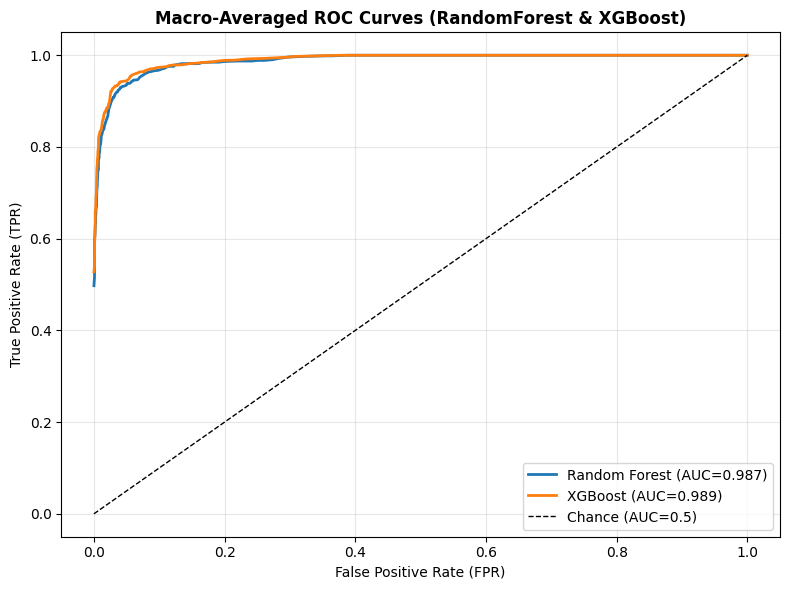

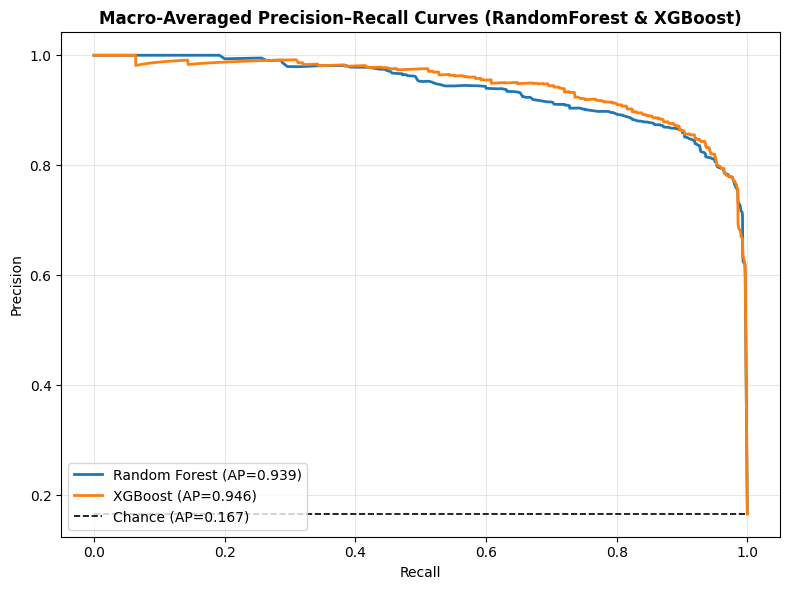

In [22]:
# ROC PLOT
plt.figure(figsize=(8,6))
for name, (fpr, mean_tpr, auc_val) in roc_results_extra.items():
    plt.plot(fpr, mean_tpr, lw=2, label=f"{name} (AUC={auc_val:.3f})")
plt.plot([0,1],[0,1],'k--',lw=1,label="Chance (AUC=0.5)")
plt.title("Macro-Averaged ROC Curves (RandomForest & XGBoost)", weight='bold')
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# PRC PLOT
plt.figure(figsize=(8,6))
pos_frac = y_test_bin.sum() / y_test_bin.size
for name, (rec, prec, ap_val) in prc_results_extra.items():
    plt.plot(rec, prec, lw=2, label=f"{name} (AP={ap_val:.3f})")
plt.plot([0,1],[pos_frac,pos_frac],'k--',lw=1.2,label=f"Chance (AP={pos_frac:.3f})")
plt.title("Macro-Averaged Precision–Recall Curves (RandomForest & XGBoost)", weight='bold')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [23]:
extra_df = pd.DataFrame(extra_results).sort_values(by="Macro AUC", ascending=False)
display(extra_df.style.background_gradient(subset=["Accuracy","Weighted F1","Macro AUC","Macro AP"]))

,Model,Accuracy,Weighted F1,Macro AUC,Macro AP
1,XGBoost,0.919969,0.917525,0.989042,0.946057
0,Random Forest,0.910645,0.907112,0.987373,0.938737


### Inference and Discussion

- Both **XGBoost** and **Random Forest** outperform all previous baseline models (KNN, SVM, Logistic Regression, etc.) across all evaluation metrics.
- **XGBoost** achieves the highest overall performance, with:
  - The **highest accuracy (≈0.92)** and **weighted F1-score (≈0.92)**,
  - A **macro-averaged ROC-AUC of 0.989**, indicating strong separability across classes,
  - And the **highest macro-averaged Average Precision (AP) of 0.946**, confirming excellent precision–recall tradeoff.

- **Random Forest** performs almost identically, suggesting that the dataset benefits from ensemble-based variance reduction, but **boosting (XGBoost)** provides a slight edge through sequential error correction.


### Comparison to Recommended Model (KNN)
| Metric | KNN | XGBoost (Best) | Improvement |
|:--------|:--------------|:----------------------|:-------------|
| Macro AUC | 0.980 | 0.989 | +0.9% |
| Macro AP | 0.921 | 0.946 | +2.5% |

## 2. Model class whose AUC < 0.5.
For this part of the analysis, we needed to identify or create a model whose performance is **worse than random chance** (AUC < 0.5).  
In practice, standard classifiers almost never perform below chance unless something is systematically wrong for example, **inverted decision boundaries**, **flipped labels**, or **misaligned features**.  
Instead of relying on randomness, we deliberately constructed such a scenario using **Logistic Regression**, a simple and interpretable linear model.  
By **inverting its predicted probabilities**, we simulate a model that makes confident but consistently incorrect predictions, providing a clear example of how metrics behave when a classifier is actively misleading rather than merely uninformative.

Normally, Logistic Regression outputs probabilities representing the model’s confidence in each class.  
Here, these probabilities were **inverted** (`1 - p`) and renormalized to sum to 1 for each sample.  
This intentionally reverses the model’s logic, classes it believes are least likely now receive the highest scores, and vice versa.  
This setup effectively models a classifier that “learned everything backward.”

Accuracy: 0.285159
Weighted F1: 0.169775
Macro AUC: 0.028004
Macro AP: 0.090401


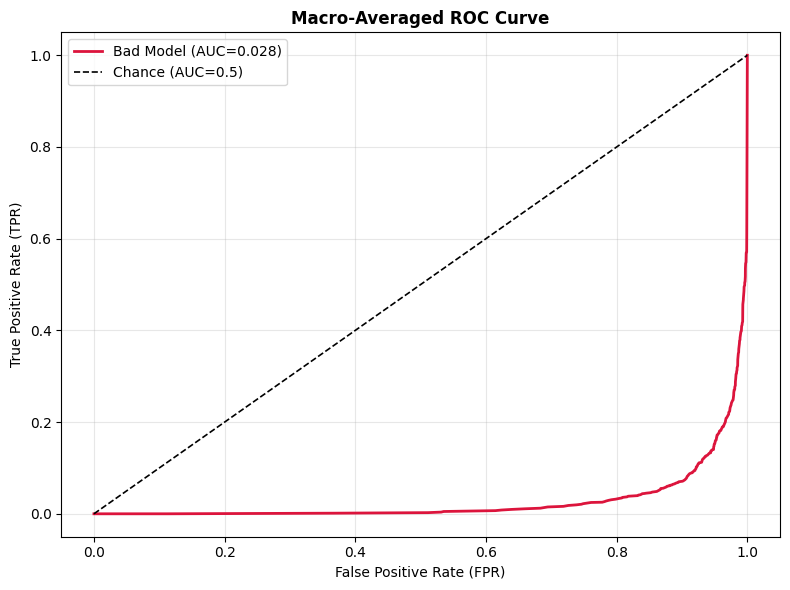

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    average_precision_score, roc_curve, precision_recall_curve
)
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Fit a simple Logistic Regression
log_bad = LogisticRegression(max_iter=1000, random_state=42)
log_bad.fit(X_train, y_train)

# Predicted probabilities
probs = log_bad.predict_proba(X_test)

# Invert probabilities to make performance worse than chance
probs_inverted = 1 - probs
probs_inverted = probs_inverted / probs_inverted.sum(axis=1, keepdims=True)

# Predicted labels
y_pred_bad = probs_inverted.argmax(axis=1)

# Binarize labels for ROC/AUC
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

# Metrics
acc = accuracy_score(y_test, y_pred_bad)
f1 = f1_score(y_test, y_pred_bad, average='weighted')
auc = roc_auc_score(y_test_bin, probs_inverted, average='macro', multi_class='ovr')
ap = average_precision_score(y_test_bin, probs_inverted, average='macro')

print(f"Accuracy: {acc:.6f}")
print(f"Weighted F1: {f1:.6f}")
print(f"Macro AUC: {auc:.6f}")
print(f"Macro AP: {ap:.6f}")

# ROC PLOT (Macro-Averaged)
fpr, tpr = {}, {}
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs_inverted[:, i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(classes)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(classes)

plt.figure(figsize=(8,6))
plt.plot(all_fpr, mean_tpr, lw=2, label=f"Bad Model (AUC={auc:.3f})", color='crimson')
plt.plot([0,1],[0,1],'k--',lw=1.2,label="Chance (AUC=0.5)")
plt.title("Macro-Averaged ROC Curve", weight='bold')
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Interpretation
- The **accuracy (28.5%)** and **weighted F1 (0.17)** indicate that the classifier performs dramatically worse than chance across all classes.  
- The **macro AUC (0.028)** far below 0.5 confirms that the model systematically ranks incorrect classes above the true labels.  
- The **average precision (0.09)** is extremely low, showing that the model’s predictions degrade quickly as recall increases.  